Prerequisites:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline

import sktime
from sktime.datasets import load_shampoo_sales , load_from_tsfile
from sktime.utils.plotting import plot_series
from sktime.transformations.series.outlier_detection import HampelFilter

# Classifiers:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifier

#Transformers:
from sktime.transformations.panel.tsfresh import TSFreshFeatureExtractor
from sktime.transformations.panel.rocket import Rocket

## Loading data:

Data retrieved from : https://www.timeseriesclassification.com/dataset.php
This dataset was formatted by R. Olszewski as part of his thesis “Generalized feature extraction for structural	pattern recognition in time-series data,” at Carnegie Mellon University, 2001.

Dataset contains measurements from a sensor during the process of semiconducter fabrication. The two classes are normal and abnormal.

In [2]:
# Loading data from .ts file
# Taking only a part of the data otherwise, it will take long time to train and test.
X , y = load_from_tsfile( "Wafer/Wafer_TRAIN.ts"  )
X_train = X.iloc[:200,:]
y_train = y[:200]

X_test , y_test = load_from_tsfile( "Wafer/Wafer_TEST.ts"  )
X_test = X_test.iloc[:1000,:]
y_test = y_test[:1000]

print(X_train.shape ,y_train.shape )
print(X_test.shape ,y_test.shape)

(200, 1) (200,)
(1000, 1) (1000,)


In [3]:
np.unique(y_train , return_counts=True)

(array(['-1', '1'], dtype='<U2'), array([ 27, 173], dtype=int64))

Imbalanced dataset


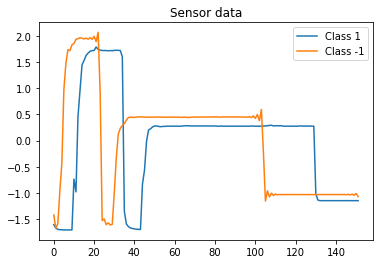

In [4]:
# Plotting data from 2 different classes
plt.plot(X.iloc[0,0] , label="Class 1" )
plt.plot(X.iloc[9,0], label="Class -1")
plt.title("Sensor data")
plt.legend()

## Transformation:

Extracting various information from time series can help us to classify them. This feature extraction process can be done using tsfresh module. It is a different module than sktime but, also included in the sktime library. 

In this process, multiple features are calculated for each series such as autocorrelation statistics, absolute summations, entropies and duplicates.


In [5]:
# TS feature extraction instance:
t = TSFreshFeatureExtractor(default_fc_parameters="efficient", show_warnings=False)
# Fitting and transforming training set 
Xt = t.fit_transform(X_train)
# Only transforming the test set(not fitting, since that would be learning the test set and wouldnt be practical)
Xtest = t.transform(X_test)
Xt.head()

Feature Extraction: 100%|██████████████████████████████████████████████████████████| 1000/1000 [01:37<00:00, 10.23it/s]


,dim_0__variance_larger_than_standard_deviation,dim_0__has_duplicate_max,dim_0__has_duplicate_min,dim_0__has_duplicate,dim_0__sum_values,dim_0__abs_energy,dim_0__mean_abs_change,dim_0__mean_change,dim_0__mean_second_derivative_central,dim_0__median,...,dim_0__permutation_entropy__dimension_6__tau_1,dim_0__permutation_entropy__dimension_7__tau_1,dim_0__query_similarity_count__query_None__threshold_0.0,"dim_0__matrix_profile__feature_""min""__threshold_0.98","dim_0__matrix_profile__feature_""max""__threshold_0.98","dim_0__matrix_profile__feature_""mean""__threshold_0.98","dim_0__matrix_profile__feature_""median""__threshold_0.98","dim_0__matrix_profile__feature_""25""__threshold_0.98","dim_0__matrix_profile__feature_""75""__threshold_0.98",dim_0__mean_n_absolute_max__number_of_maxima_7
0,0.0,0.0,1.0,1.0,5.900000e-08,150.999999,0.073559,0.003026,0.000228,0.275122,...,2.814940,3.210021,0.0,1.992490,7.290039,4.590458,4.447286,3.299824,5.987825,1.734632
1,0.0,1.0,1.0,1.0,2.640000e-06,151.000001,0.053254,-0.000128,0.000000,0.149323,...,2.493239,2.823889,0.0,1.592576,6.644166,3.069368,2.603529,1.887681,4.166875,1.084591
2,0.0,0.0,1.0,1.0,7.000000e-08,151.000002,0.177475,0.000203,0.000000,-0.341733,...,3.146638,3.709556,0.0,1.138673,5.780368,4.528510,4.893145,3.882078,5.190581,2.402725
3,0.0,0.0,1.0,1.0,5.350000e-07,150.999999,0.058836,-0.000015,0.000000,0.407168,...,2.874027,3.169620,0.0,1.205840,6.651399,2.912498,2.607068,1.940151,3.586077,1.096732
4,0.0,0.0,1.0,1.0,1.463000e-06,150.999997,0.057819,0.000000,0.000000,0.352437,...,2.971568,3.270495,0.0,1.184827,6.272190,2.697131,2.400886,1.868804,3.148360,1.105914


783 features extracted from every single time series.

## Classification

Classifying the time series features using an sklearn classifier.

In [6]:
classifier = RandomForestClassifier()
classifier.fit(Xt, y_train)

RandomForestClassifier()

In [7]:
classifier.score(Xtest,y_test)

1.0

Perfectly classifies.

## Pipelining:

Instead of transforming train and test seperately, using a pipeline will be easier to implement.

In [8]:
classifier = make_pipeline(
    
    # ROCKET TRANSFORM:
    Rocket(), 
    
    # Classifier:
    RidgeClassifier(alpha=1)

)
classifier.fit(X_train, y_train)

C:\Users\a\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=2.22103e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


Pipeline(steps=[('rocket', Rocket()),
                ('ridgeclassifier', RidgeClassifier(alpha=1))])

In [9]:
classifier.score(X_test, y_test)

0.997

## Outlier detection example:

<AxesSubplot:xlabel='Period'>

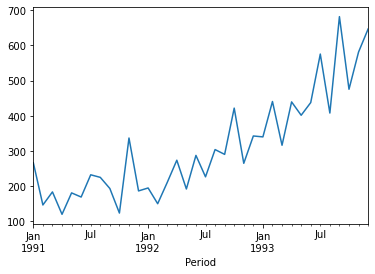

In [10]:
# A built-in dataset is used
y = load_shampoo_sales()
y.plot()

Outlier detection using hampel filter:

In [11]:
transformer = HampelFilter(window_length=12 , return_bool=True , n_sigma=2) # default sigma=3
y_hat = transformer.fit_transform(y)
outliers = y[y_hat]
print(str(outliers.count()) + " outlier(s) found.")
new_y = y[y_hat==False]

4 outlier(s) found.


(<Figure size 1152x288 with 1 Axes>,
 <AxesSubplot:ylabel='Number of shampoo sales'>)

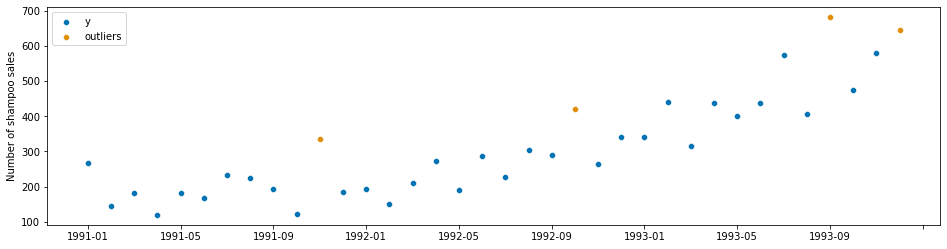

In [12]:
plot_series(new_y,outliers,labels=["y","outliers"])